# Guessing game

Loosely following Lazaridou et al. (2017).

In [1]:
import importlib

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.compat.v1.disable_eager_execution()

In [2]:
IMG_EMB_FILE = "data/vgg19-10000.emb.gz"
# IMG_EMB_FILE = "data/xception-10000.emb.gz"
N_SYMBOLS = 10
N_CHOICES = 2
EMB_SIZE = 50
N_IMAGES = 500
BATCH_SIZE = 30

In [3]:
from tools.tools import load_emb_gz
_, fnames, embs = load_emb_gz(IMG_EMB_FILE, N_IMAGES)
IMG_SHAPE = embs[0].shape
IMG_N = len(embs)
IMG_SHAPE, IMG_N

DONE. 500 items loaded from data/vgg19-10000.emb.gz.


((1000,), 500)

In [4]:
def smooth_avg(old, new, new_weight=1):
    if old is None:
        return new
    return (old + new * new_weight)/(1 + new_weight)

## Set up model

In [5]:
BATCH_SIZE = 30

In [6]:
import game.game as game
import agent.reinforce_agent as agent
from keras.optimizers import Adam, SGD, Adagrad, Nadam
importlib.reload(agent)
importlib.reload(game)

sender = agent.Sender(input_sizes=[IMG_SHAPE, IMG_SHAPE],
                      output_size=N_SYMBOLS,
                      n_symbols=N_SYMBOLS,
                      embedding_size=50,
                      learning_rate=0.001,
                      gibbs_temp=10,
                      use_bias=False,
                      optimizer=Adam)
# sender = agent.SenderInformed(input_sizes=[IMG_SHAPE, IMG_SHAPE],
#                               output_size=N_SYMBOLS,
#                               n_symbols=N_SYMBOLS,
#                               n_filters=20,
#                               embedding_size=50,
#                               learning_rate=0.001,
#                               gibbs_temp=10,
#                               use_bias=False,
#                               optimizer=Adam)
receiver = agent.Receiver(input_sizes=[IMG_SHAPE, IMG_SHAPE, (1,)],
                          output_size=N_CHOICES,
                          n_symbols=N_SYMBOLS,
                          embedding_size=50,
                          learning_rate=0.001,
                          gibbs_temp=10,
                          mode="dot",  # original with dot product output
                          # mode="dense",  # dense layer + sigmoid instead
                          # mode="cosine",  # cosine distance (= norm and dot)
                          use_bias=False,
                          optimizer=Adam)
g = game.Game(images=embs,
              images_filenames=fnames,
              sender=sender,
              receiver=receiver,
              reward_sender={"success": 1, "fail": 0},
              reward_receiver={"success": 1, "fail": 0})

Using TensorFlow backend.


<IPython.core.display.Javascript object>


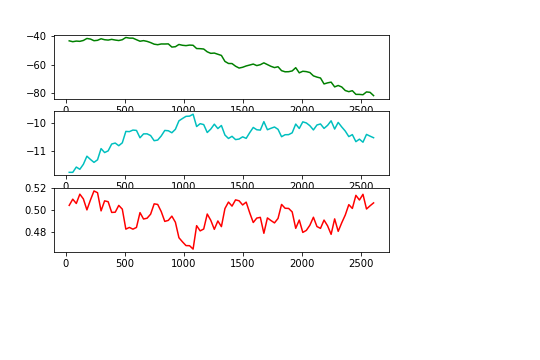

KeyboardInterrupt: 

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
plt.ion()

fig.show()
fig.canvas.draw()

t = []
show_steps = 2500
batch_success = []
success_rate = []
sendr_loss = []
recvr_loss = []
success_rate_avg = 0.5
sendr_loss_avg = None
recvr_loss_avg = None
for i in range(10000):
    g.reset()
    sender_state = g.get_sender_state(n_images=N_CHOICES)
    sender_action, sender_prob = sender.act(sender_state)
    receiver_state = g.get_receiver_state(sender_action)
    receiver_action, receiver_prob = receiver.act(receiver_state)
    sender_reward, receiver_reward, success = g.evaluate_guess(receiver_action)
    sender.remember(sender_state, sender_action, sender_reward)
    receiver.remember(receiver_state, receiver_action, receiver_reward)
    batch_success.append(success)

    # TRAIN
    if i and not i % BATCH_SIZE:
        avg_success = sum(batch_success)/len(batch_success)
        batch_success = []
        sender.batch_train()
        receiver.batch_train()
        # PLOT PROGRESS
        t.append(i)
        success_rate_avg = smooth_avg(success_rate_avg, avg_success, 0.1)
        sendr_loss_avg = smooth_avg(sendr_loss_avg, sender.last_loss, 0.1)
        recvr_loss_avg = smooth_avg(recvr_loss_avg, receiver.last_loss, 0.1)
        success_rate.append(success_rate_avg)
        sendr_loss.append(sendr_loss_avg)
        recvr_loss.append(recvr_loss_avg)
        #       print(success, sender.last_loss, receiver.last_loss)
        ax1.clear()
        ax2.clear()
        ax3.clear()
        ax1.plot(t[-show_steps:], sendr_loss[-show_steps:], "g")
        ax2.plot(t[-show_steps:], recvr_loss[-show_steps:], "c")
        ax3.plot(t[-show_steps:], success_rate[-show_steps:], "r")
        fig.canvas.draw()
        fig.canvas.flush_events()

In [38]:
sender.last_weights

In [37]:
sender.last_loss

nan

In [ ]:
sender.save("sender.weights")
receiver.save("receiver.weights")


In [ ]:
sender.load("sender.weights")
receiver.load("receiver.weights")


In [12]:
import numpy as np
from keras.models import Model
import keras.layers as layers
import keras.optimizers as optim
import keras.backend as K
import keras.models as models

In [13]:
x = [np.expand_dims(img, 0) for img in embs[:2]]

In [74]:
n_inputs = 2
n_filters = 20
input_sizes = [IMG_SHAPE, IMG_SHAPE]
embedding_size = 50
output_size = 10

inputs = [layers.Input(shape=input_sizes[i], name=f"input_{i}")
          for i in range(n_inputs)]
embs = [layers.Dense(embedding_size, name=f"embed_{i}")
        for i in range(n_inputs)]

imgs = [embs[i](inputs[i]) for i in range(n_inputs)]


stack = layers.Lambda(lambda x: K.stack(x, axis=1), name="stack")
#trans1 = layers.Lambda(lambda x: K.permute_dimensions(x, (0,2,1)), name="transpose_1")
reshape = layers.Reshape((-1, embedding_size, 1))
feat_filters = layers.Conv2D(filters=n_filters, 
                             kernel_size=(2, 1),
                             activation="sigmoid",
                             #padding="same",
                             #strides=embedding_size,
                             #data_format="channels_last",
                             name="feature_filters"
                             )

trans2 = layers.Lambda(lambda x: K.permute_dimensions(x, (0,2,1)), name="transpose_2")
voc_filter = layers.Conv2D(1, (1, n_filters),
                           #padding="same",
                           data_format="channels_first",
                           name="vocab_filter"
                           )
dense = layers.Dense(output_size, name="output_dense")

#out = voc_filter(feat_filters(stack(imgs)))
#out = voc_filter(feat_filters(trans1(stack(imgs))))
out = layers.Flatten()(voc_filter(feat_filters(reshape(stack(imgs)))))

temp = layers.Lambda(lambda x: x / 10, name="gibbs_temp")
soft = layers.Activation("softmax", name="softmax")
#predict_out = soft(temp(out))
#predict_out = soft(temp(out))
#train_out = soft(out)

model = Model(inputs, out)
model.summary()

Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embed_0 (Dense)                 (None, 50)           50050       input_0[0][0]                    
__________________________________________________________________________________________________
embed_1 (Dense)                 (None, 50)           50050       input_1[0][0]                    
___________________________________________________________________________________________

In [49]:
x[0]

array([[4.1000e-04, 8.0000e-05, 1.2000e-04, 2.6000e-04, 1.6000e-04,
        2.6000e-04, 1.8000e-04, 1.7000e-04, 1.2000e-04, 7.0000e-05,
        1.2000e-04, 7.0000e-05, 2.3000e-04, 1.3000e-04, 1.8000e-04,
        1.8000e-04, 2.2000e-04, 2.1000e-04, 9.0000e-05, 1.0000e-04,
        2.2000e-04, 3.0000e-04, 1.4000e-04, 1.9000e-04, 2.0000e-04,
        1.4000e-04, 1.3000e-04, 1.3000e-04, 2.9000e-04, 2.2000e-04,
        1.2000e-04, 1.4000e-04, 1.8000e-04, 1.7000e-04, 1.9000e-04,
        2.4000e-04, 2.2000e-04, 1.5000e-04, 2.4000e-04, 1.0000e-04,
        1.2000e-04, 1.6000e-04, 1.4000e-04, 1.9000e-04, 2.2000e-04,
        1.9000e-04, 9.0000e-05, 1.1000e-04, 1.0000e-04, 2.1000e-04,
        2.5000e-04, 9.0000e-05, 5.5000e-04, 2.4000e-04, 2.8000e-04,
        2.2000e-04, 2.5000e-04, 1.1000e-04, 1.3000e-04, 1.7000e-04,
        1.2000e-04, 1.2000e-04, 1.1000e-04, 3.5000e-04, 1.8000e-04,
        1.7000e-04, 3.3000e-04, 1.4000e-04, 2.3000e-04, 2.2000e-04,
        1.7000e-04, 1.0000e-04, 1.9000e-04, 1.30

In [50]:
model.predict(x)

array([[0.05001471, 0.05000148, 0.05000439, 0.049971  , 0.05000331,
        0.05001214, 0.04997662, 0.05002727, 0.04999667, 0.04999293,
        0.049991  , 0.04997314, 0.04999671, 0.05002567, 0.05002342,
        0.04996717, 0.05000954, 0.05000596, 0.05000328, 0.05000358]],
      dtype=float32)

In [ ]:
n_inputs = 2
n_filters = 20
input_sizes = [IMG_SHAPE, IMG_SHAPE]
embedding_size = 50
output_size = 10

inputs = [layers.Input(shape=input_sizes[i])
             for i in range(n_inputs)]
emb_layers = [layers.Dense(embedding_size)
              for i in range(n_inputs)]

imgs = [emb_layers[i](inputs[i]) for i in range(n_inputs)]

stack_layer = layers.Lambda(lambda x: K.stack(x, axis=1))
trans_layer = layers.Lambda(lambda x: K.permute_dimensions(x, (0,2,1)))
cnn1_layer = layers.Conv1D(filters=n_filters, 
                           kernel_size=n_inputs, 
                           activation="sigmoid")

voc_filter = layers.Conv1D(filters=1, 
                           kernel_size=n_filters,
                           #padding="same")
dense = layers.Dense(output_size, name="output_dense")

out = voc_filter(feat_filters(trans1(stack(imgs))))

temp = layers.Lambda(lambda x: x / 10, name="gibbs_temp")
soft = layers.Activation("softmax", name="softmax")
#predict_out = soft(temp(out))
predict_out = soft(temp(out))
#train_out = soft(out)

model = Model(inputs, predict_out)
model.summary()